# TEST CLIMATOLOGICAL OUTLIERS FUNCTION

In [32]:
# Import libraries
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import QAQC libraries

In [2]:
import os
import tempfile
import argparse 

# Import all qaqc script functions
try:
    from qaqc_plot import *
    from qaqc_utils import *
    from qaqc_wholestation import *
    from qaqc_logic_checks import *
    from qaqc_buoy_check import *
    from qaqc_frequent import *
    from qaqc_unusual_gaps import *
    from qaqc_unusual_large_jumps import *
    from qaqc_climatological_outlier import *
    from qaqc_unusual_streaks import *
except Exception as e:
    print("Error importing qaqc script: {}".format(e))

# Import qaqc stage calc functions
try:
    from QAQC_pipeline import *
except:
    print("Error importing QAQC_pipeline.py")
    
if not os.path.exists("./qaqc_figs"):
    os.makedirs("./qaqc_figs")

## Load file and convert to pandas df 

In [314]:
""" Aqaqc_world_recordtions from QAQC libraries can be used here.
    For the qaqc pipeline, we need the pandas df in the same format used in it
"""

network = "RAWS"
rawdir, cleandir, qaqcdir, mergedir = get_file_paths(network)
print(rawdir)
print(cleandir)
print(qaqcdir)
print(mergedir)

1_raw_wx/RAWS/
2_clean_wx/RAWS/
3_qaqc_wx/RAWS/
4_merge_wx/RAWS/


In [315]:
ls Train_Files/RAWS*

Train_Files/RAWS_KBNC1.nc  Train_Files/RAWS_TT454.nc
Train_Files/RAWS_PKLC2.nc  Train_Files/RAWS_UINU1.nc
Train_Files/RAWS_TFRU1.nc  Train_Files/RAWS_ZMBA2.nc


In [316]:
""" We can test in the same way that the pipeline, 
    take a network and subsample an station
"""

files, stations = read_network_files(network, cleandir)
stations_sample = stations.sample(1)
station = stations_sample.iloc[0]

station = "RAWS_TFRU1"
station = "RAWS_UINU1"

print(station)
print("Train_Files/{}.nc".format(station))

RAWS_UINU1
Train_Files/RAWS_UINU1.nc


In [317]:
%%time

""" We could load station files from the 
    s3 bucket
"""
file_name = cleandir + station + ".nc"
aws_url = "s3://wecc-historical-wx/"+file_name

try:
    print("open file locally")
    ds = xr.open_dataset("Train_Files/{}.nc".format(station)).load()
except:
    print("file not found locally, opening from s3 bucket")
    fs = s3fs.S3FileSystem()
    with fs.open(aws_url) as fileObj:
        ds = xr.open_dataset(fileObj).load()
df, MultiIndex, attrs, var_attrs = qaqc_ds_to_df(ds)        

open file locally
CPU times: user 289 ms, sys: 66.2 ms, total: 355 ms
Wall time: 414 ms


In [318]:
df.head()

,time,tas,pr,hurs,rsds,sfcWind,sfcWind_dir,tas_qc,hurs_qc,sfcWind_qc,...,tdps_derived_eraqc,elevation_eraqc,anemometer_height_m,thermometer_height_m,station,hour,day,month,year,date
0,2002-05-16 08:45:00,288.71,0.0,23.0,0.0,0.45,260.0,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_UINU1,8,16,5,2002,2002-05-16
1,2002-05-16 09:45:00,289.26,0.0,21.0,0.0,1.34,180.0,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_UINU1,9,16,5,2002,2002-05-16
2,2002-05-16 10:45:00,288.71,0.0,27.0,0.0,0.90,350.0,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_UINU1,10,16,5,2002,2002-05-16
3,2002-05-16 11:45:00,287.59,0.0,37.0,0.0,4.92,20.0,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_UINU1,11,16,5,2002,2002-05-16
4,2002-05-16 12:45:00,287.04,0.0,40.0,42.0,3.58,350.0,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_UINU1,12,16,5,2002,2002-05-16


## Log file and error handling

In [319]:
# Set up error handling.
errors, end_api, timestamp = setup_error_handling()

In [320]:
global log_file
log_file = open("logtest.log","w")
verbose=True

## Whole station and logic checks

### Part 1a: Whole station checks - if failure, entire station does not proceed through QA/QC

In [321]:
t0 = time.time()
printf("QA/QC whole station tests", log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:41 : 	 QA/QC whole station tests


In [322]:
#---------------------------------------------------------
## Missing values -- does not proceed through qaqc if failure
stn_to_qaqc = df.copy()  # Need to define before qaqc_pipeline, in case 
new_df = qaqc_missing_vals(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_missing_vals', log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:41 : 	 Running: qaqc_missing_vals
06-28-2024 16:48:41 : 	 Updating missing values for: tas
06-28-2024 16:48:41 : 	 Updating missing values for: pr
06-28-2024 16:48:41 : 	 Updating missing values for: hurs
06-28-2024 16:48:41 : 	 Updating missing values for: rsds
06-28-2024 16:48:41 : 	 Updating missing values for: sfcWind
06-28-2024 16:48:41 : 	 Updating missing values for: sfcWind_dir
06-28-2024 16:48:41 : 	 Updating missing values for: tdps_derived
06-28-2024 16:48:41 : 	 pass qaqc_missing_vals


In [323]:
#---------------------------------------------------------
## Lat-lon -- does not proceed through qaqc if failure
new_df = qaqc_missing_latlon(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_missing_latlon', log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:41 : 	 Running: qaqc_missing_latlon
06-28-2024 16:48:41 : 	 pass qaqc_missing_latlon


In [324]:
#---------------------------------------------------------
## Within WECC -- does not proceed through qaqc if failure
new_df = qaqc_within_wecc(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_within_wecc', log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:41 : 	 Running: qaqc_within_wecc
06-28-2024 16:48:42 : 	 pass qaqc_within_wecc


In [325]:
#---------------------------------------------------------
## Elevation -- if DEM in-filling fails, does not proceed through qaqc
new_df = qaqc_elev_infill(stn_to_qaqc, verbose=verbose) # nan infilling must be before range check
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_elev_infill', log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:42 : 	 Running: qaqc_elev_infill
06-28-2024 16:48:42 : 	 pass qaqc_elev_infill


In [326]:
#---------------------------------------------------------
## Elevation -- range within WECC
new_df = qaqc_elev_range(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_elev_range', log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:42 : 	 Running: qaqc_elev_range
06-28-2024 16:48:42 : 	 Elevation values post-infilling/correcting: [1502.0544]
06-28-2024 16:48:42 : 	 pass qaqc_elev_range


### Part 1b: Whole station checks - if failure, entire station does proceed through QA/QC

In [327]:
## Pressure units fix (temporary)
new_df = qaqc_pressure_units_fix(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_pressure_units_fix', log_file=log_file, verbose=verbose, flush=True)    

06-28-2024 16:48:42 : 	 Running: qaqc_pressure_units_fix
06-28-2024 16:48:42 : 	 pass qaqc_pressure_units_fix


In [328]:
#---------------------------------------------------------
## World record checks: air temperature, dewpoint, wind, pressure
new_df = qaqc_world_record(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_world_record', log_file=log_file, verbose=verbose, flush=True)

printf("Done whole station tests, Ellapsed time: {:.2f} s.\n".format(time.time()-t0), log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:42 : 	 Running: qaqc_world_record
06-28-2024 16:48:43 : 	 pass qaqc_world_record
06-28-2024 16:48:43 : 	 Done whole station tests, Ellapsed time: 1.64 s.



In [329]:
printf("Done whole station tests, Ellapsed time: {:.2f} s.\n".format(time.time()-t0), log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:43 : 	 Done whole station tests, Ellapsed time: 1.66 s.



### Part 2: Variable logic checks

In [330]:
t0 = time.time()
printf("QA/QC logic checks", log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:43 : 	 QA/QC logic checks


In [331]:
#---------------------------------------------------------
## dew point temp cannot exceed air temperature
new_df = qaqc_crossvar_logic_tdps_to_tas_supersat(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_crossvar_logic_tdps_to_tas_supersat', log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:44 : 	 Running: qaqc_crossvar_logic_tdps_to_tas_supersat
06-28-2024 16:48:44 : 	 pass qaqc_crossvar_logic_tdps_to_tas_supersat


In [332]:
#---------------------------------------------------------
## dew point temp cannot exceed air temperature (wet bulb drying)  
new_df = qaqc_crossvar_logic_tdps_to_tas_wetbulb(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_crossvar_logic_tdps_to_tas_wetbulb', log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:44 : 	 Running: qaqc_crossvar_logic_tdps_to_tas_wetbulb
06-28-2024 16:48:45 : 	 Flagging extended streak in dewpoint depression
06-28-2024 16:48:45 : 	 pass qaqc_crossvar_logic_tdps_to_tas_wetbulb


In [333]:
#---------------------------------------------------------
## precipitation is not negative
new_df = qaqc_precip_logic_nonegvals(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_precip_logic_nonegvals', log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:47 : 	 Running: qaqc_precip_logic_nonegvals
06-28-2024 16:48:47 : 	 Running qaqc_precip_logic_nonegvals on: ['pr']
06-28-2024 16:48:47 : 	 pass qaqc_precip_logic_nonegvals


In [334]:
#---------------------------------------------------------
## precipitation duration logic
new_df = qaqc_precip_logic_accum_amounts(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_precip_logic_accum_amounts', log_file=log_file, verbose=verbose, flush=True)      

06-28-2024 16:48:47 : 	 Running: qaqc_precip_logic_accum_amounts
06-28-2024 16:48:47 : 	 Station does not report multiple precipitation variables - bypassing precip logic accum check
06-28-2024 16:48:47 : 	 pass qaqc_precip_logic_accum_amounts


In [335]:
#---------------------------------------------------------
## wind direction should be 0 when wind speed is also 0
new_df = qaqc_crossvar_logic_calm_wind_dir(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_crossvar_logic_calm_wind_dir', log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:47 : 	 Running: qaqc_crossvar_logic_calm_wind_dir
06-28-2024 16:48:47 : 	 pass qaqc_crossvar_logic_calm_wind_dir


In [336]:
printf("Done logic checks, Ellapsed time: {:.2f} s.\n".format(time.time()-t0), log_file=log_file, verbose=verbose, flush=True)

06-28-2024 16:48:47 : 	 Done logic checks, Ellapsed time: 4.21 s.



## Test clim outliers

In [26]:
# climatological outliers
t0 = time.time()
printf("QA/QC climatological outliers", log_file=log_file, verbose=verbose, flush=True)

new_df = qaqc_climatological_outlier(stn_to_qaqc, verbose=verbose)
if new_df is None:
    errors = print_qaqc_failed(errors, station, end_api,
                            message="Flagging problem with climatological outlier check",
                            test="qaqc_climatological_outlier",
                            verbose=verbose)
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_climatological_outlier', log_file=log_file, verbose=verbose, flush=True)

printf("Done QA/QC climatological outliers, Ellapsed time: {:.2f} s.\n".format(time.time()-t0), log_file=log_file, verbose=verbose, flush=True)

In [115]:
df_test = grab_valid_obs(stn_to_qaqc, var, kind='drop')

In [116]:
clim = df_test.groupby(["month","hour"])[var].transform(lambda row:stats.mstats.winsorize(row, limits=[0.05,0.05]))
clim = pd.DataFrame(data={var:clim, "hour":df_test.hour, "month":df_test.month}, index=df_test.index)
# clim

In [117]:
clim = clim.groupby(["month","hour"])[var].transform(lambda row: np.nanmean(row))
clim = pd.DataFrame(data={var:clim, "hour":df_test.hour, "month":df_test.month}, index=df_test.index)
# clim

In [118]:
anom = df_test[var]-clim[var]
anom = pd.DataFrame(data={var:anom, "hour":df_test.hour, "month":df_test.month}, index=df_test.index)
# anom

In [119]:
iqr = anom.groupby(["month","hour"])[var].transform(lambda row: max(np.nanpercentile(row, 75)-np.nanpercentile(row, 25), 1.5))
iqr = pd.DataFrame(data={var:iqr, "hour":df_test.hour, "month":df_test.month}, index=df_test.index)
# iqr

In [120]:
std = anom[var]/iqr[var]
std = pd.DataFrame(data={var:std, "hour":df_test.hour, "month":df_test.month}, index=df_test.index)

In [151]:
# Low-pass standardised data
cut_freq = 1/(3600*24*365/30) # In Hz (cut_period : 1 month)
data_freq = 1/(df_test['time'].diff().mode().values[0].astype("float")/1e9) # In Hz
sos = signal.butter(1, cut_freq, 'lp', output='sos', fs=data_freq)
filtered = signal.sosfilt(sos, std[var].interpolate(method="linear"))
# data = std[var].interpolate(method="linear")-filtered
data = filtered
data = pd.DataFrame(data={var:data, "hour":df_test.hour, "month":df_test.month, "time":df_test.time}, index=df_test.index)
# data

<AxesSubplot:xlabel='time'>

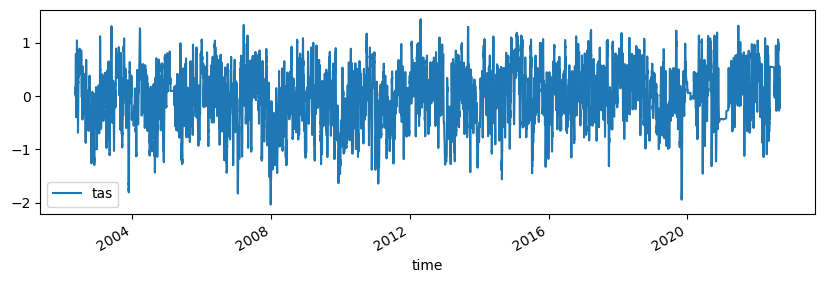

In [152]:
fig,ax = plt.subplots(figsize=(10,3))
data.plot(x="time", y="tas", ax=ax)

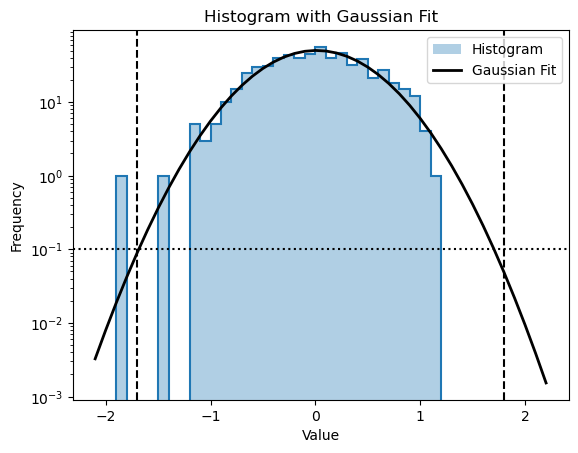

,tas,hour,month,time
145543,-1.830453,5,10,2019-10-30 05:31:00


In [169]:
series = data[(data.month==10)&(data.hour==5)]
freq, bins, p, left, right = fit_normal(series['tas'], bin_size=0.1, plot=True)
series[series['tas']<-1.6]

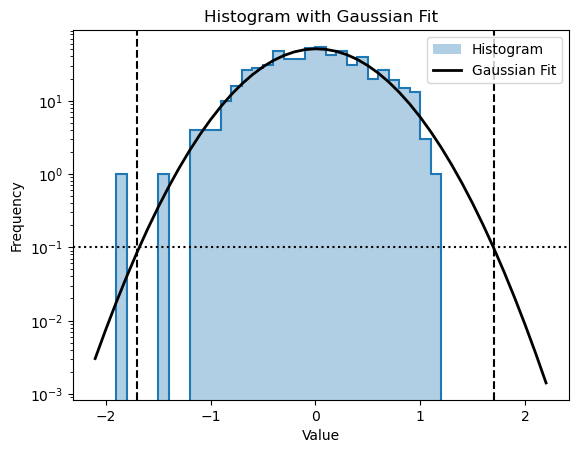

,tas,hour,month,time
145544,-1.852754,6,10,2019-10-30 06:31:00


In [170]:
series = data[(data.month==10)&(data.hour==6)]
freq, bins, p, left, right = fit_normal(series['tas'], bin_size=0.1, plot=True)
series[series['tas']<-1.6]

(250.0, 310.0)

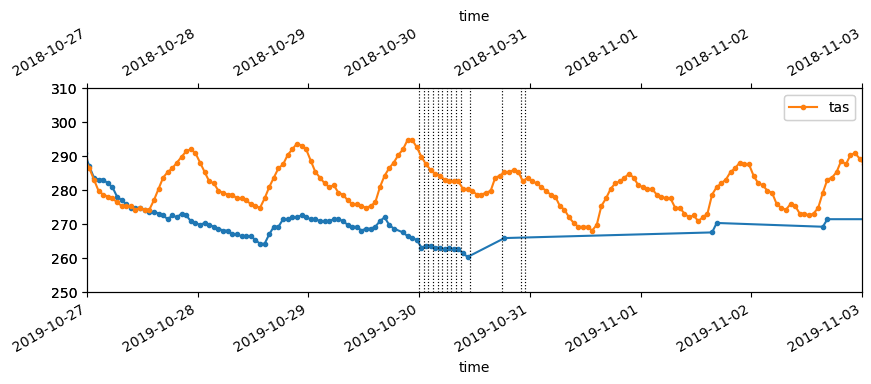

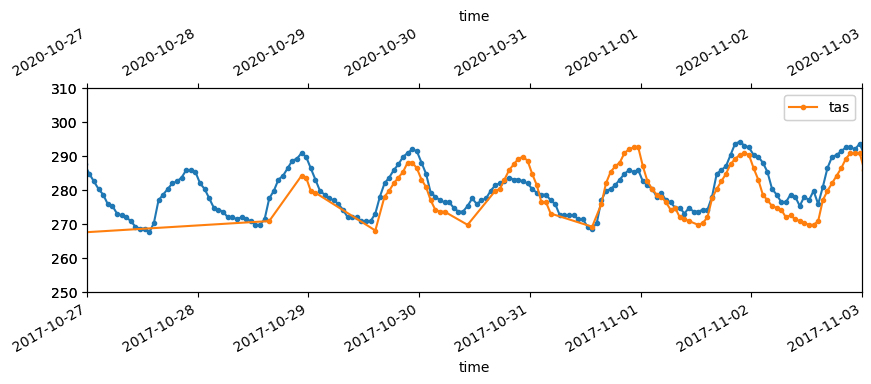

In [198]:
fig,ax = plt.subplots(figsize=(10,3))
df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2019-10-27"),np.datetime64("2019-11-03"))
# ax.axvline(np.datetime64("2019-10-30 05:31:00"), lw=0.85, ls=":", c="k")
for h in np.concatenate([np.arange(10), [11,18,22,23]]):
    ax.axvline(np.datetime64("2019-10-30 {}:00:00".format(str(h).zfill(2))), lw=0.85, ls=":", c="k")
ax.set_ylim(255,290)

axt = ax.twiny()
df.plot(x="time", y="tas", ax=axt, marker=".", color="C1")
axt.set_xlim(np.datetime64("2018-10-27"),np.datetime64("2018-11-03"))
axt.set_ylim(250,310)

fig,ax = plt.subplots(figsize=(10,3))
df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2017-10-27"),np.datetime64("2017-11-03"))
ax.set_ylim(255,290)

axt = ax.twiny()
df.plot(x="time", y="tas", ax=axt, marker=".", color="C1")
axt.set_xlim(np.datetime64("2020-10-27"),np.datetime64("2020-11-03"))
axt.set_ylim(250,310)

(255.0, 305.0)

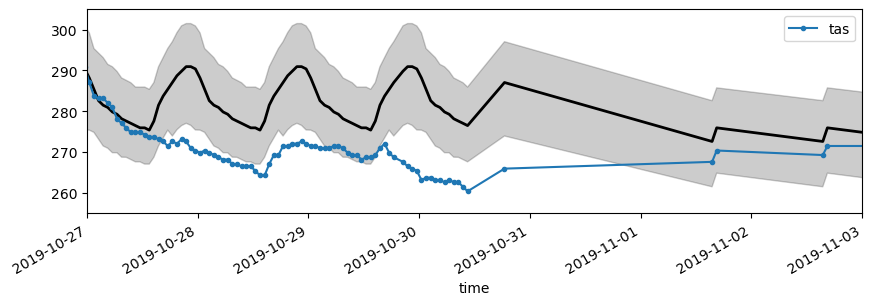

In [298]:
fig,ax = plt.subplots(figsize=(10,3))

ax.plot(df.time, df.groupby(["month","hour"]).tas.transform(lambda row: np.nanmedian(row)), lw=2, c="k")
y1 = stn_to_qaqc.groupby(["month","hour"]).tas.transform(lambda row: np.percentile(row,  1)).interpolate(method="linear")
y2 = stn_to_qaqc.groupby(["month","hour"]).tas.transform(lambda row: np.percentile(row, 99)).interpolate(method="linear")
ax.fill_between(df.time, y1, y2, color="k", alpha=0.2)

df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2019-10-27"),np.datetime64("2019-11-03"))
# ax.axvline(np.datetime64("2003-11-29 02:45:00"), ls=":", c="C0")
ax.set_ylim(255,305)

(260.0, 275.0)

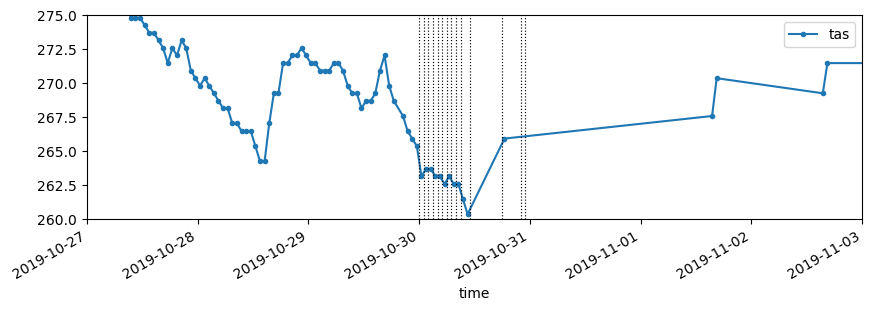

In [197]:
fig,ax = plt.subplots(figsize=(10,3))
df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2019-10-27"),np.datetime64("2019-11-03"))
# ax.axvline(np.datetime64("2019-10-30 05:31:00"), lw=0.85, ls=":", c="k")
for h in np.concatenate([np.arange(10), [11,18,22,23]]):
    ax.axvline(np.datetime64("2019-10-30 {}:00:00".format(str(h).zfill(2))), lw=0.85, ls=":", c="k")
ax.set_ylim(260,275)

0


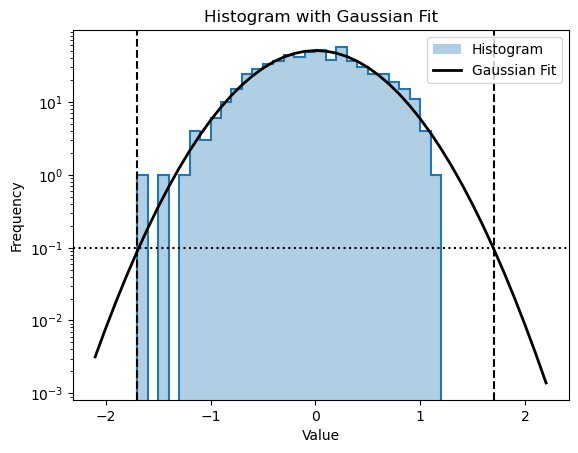

,tas,hour,month,time
145538,-1.681327,0,10,2019-10-30 00:31:00


1


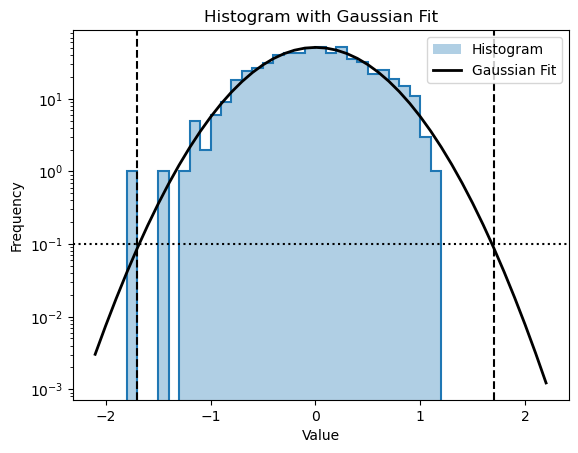

,tas,hour,month,time
145539,-1.716732,1,10,2019-10-30 01:31:00


2


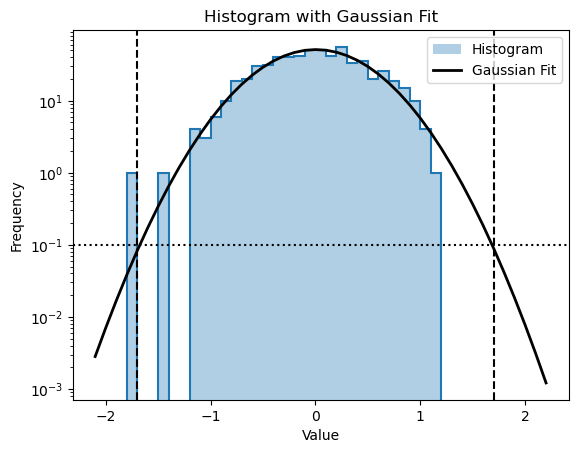

,tas,hour,month,time
145540,-1.748515,2,10,2019-10-30 02:31:00


3


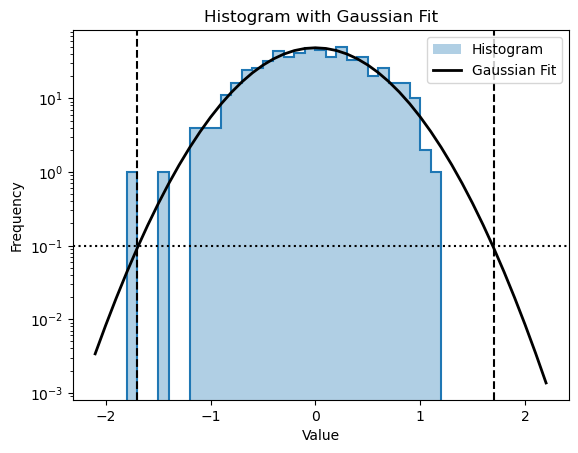

,tas,hour,month,time
145541,-1.777648,3,10,2019-10-30 03:31:00


4


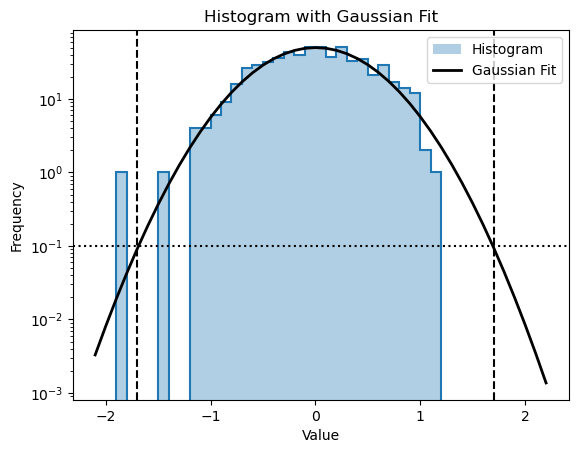

,tas,hour,month,time
145542,-1.805406,4,10,2019-10-30 04:31:00


5


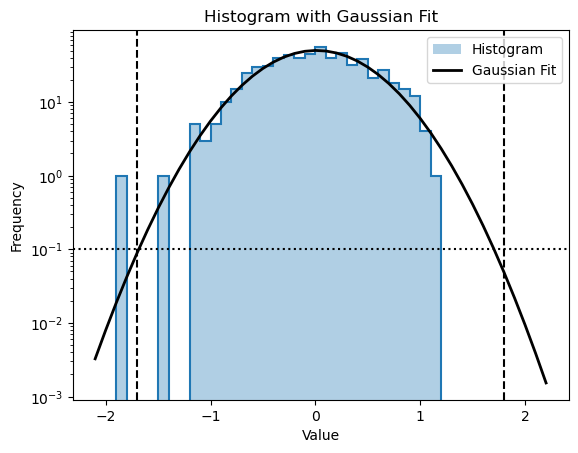

,tas,hour,month,time
145543,-1.830453,5,10,2019-10-30 05:31:00


6


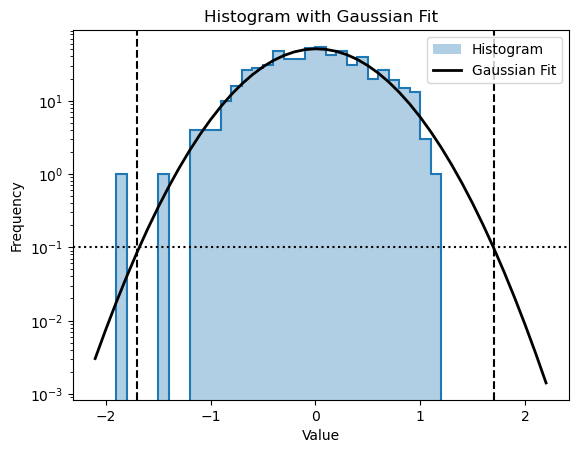

,tas,hour,month,time
145544,-1.852754,6,10,2019-10-30 06:31:00


7


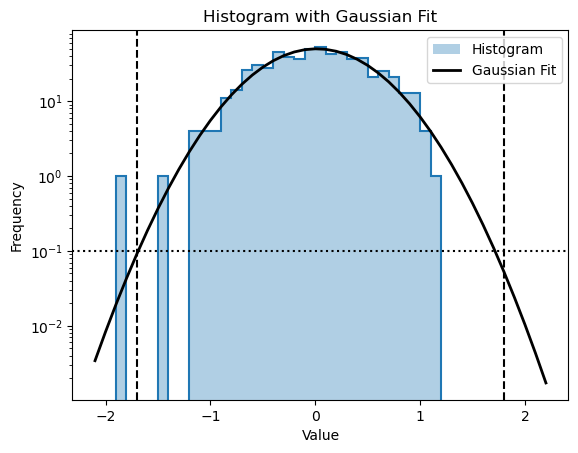

,tas,hour,month,time
145545,-1.871645,7,10,2019-10-30 07:31:00


8


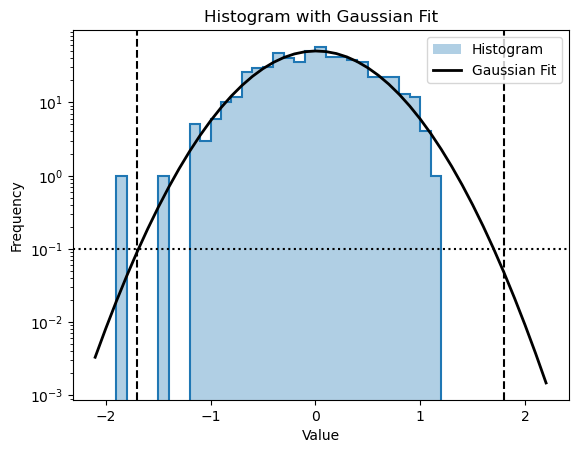

,tas,hour,month,time
145546,-1.885515,8,10,2019-10-30 08:31:00


9


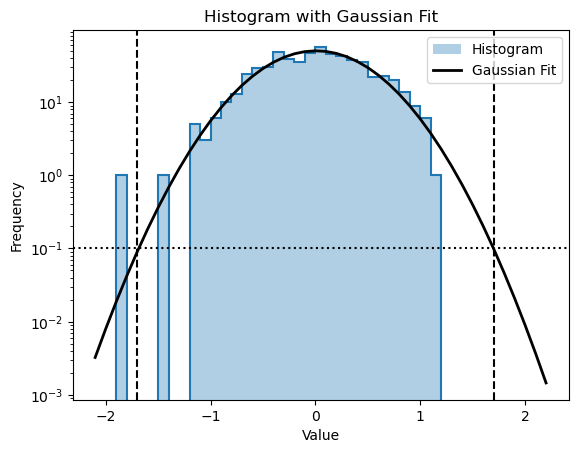

,tas,hour,month,time
145547,-1.89659,9,10,2019-10-30 09:31:00


10


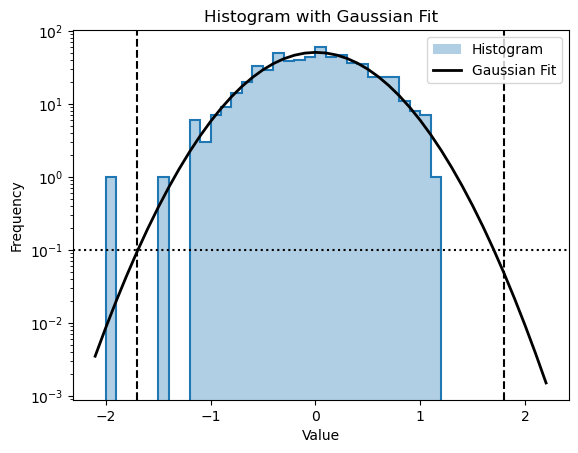

,tas,hour,month,time
145548,-1.909614,10,10,2019-10-30 10:31:00


11


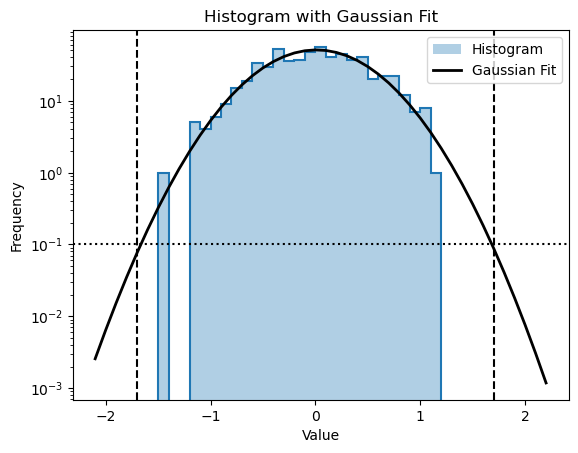

,tas,hour,month,time


12


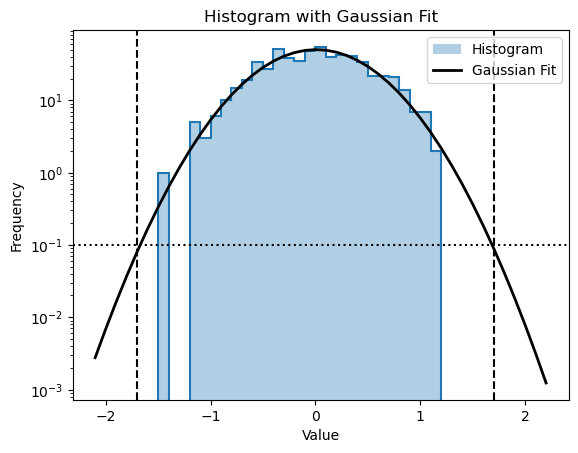

,tas,hour,month,time


13


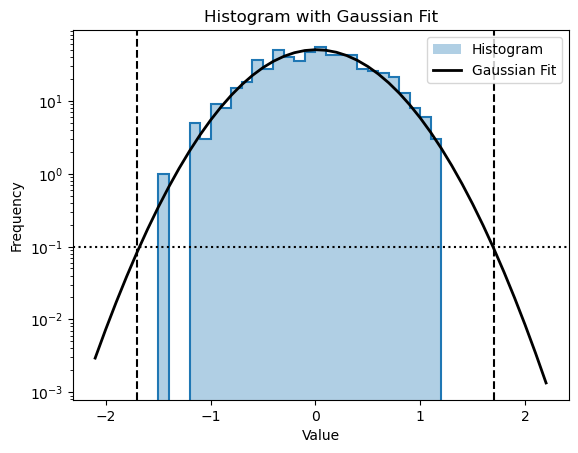

,tas,hour,month,time


14


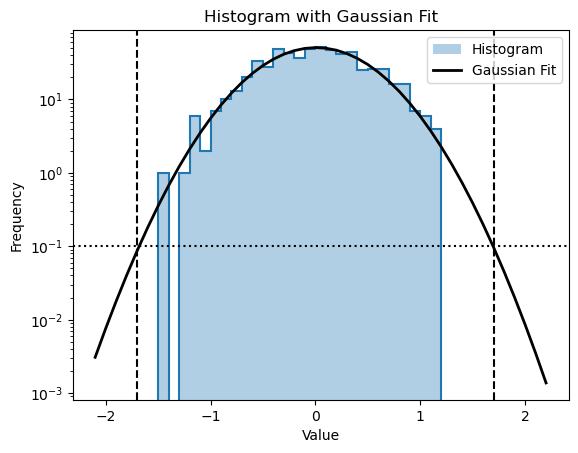

,tas,hour,month,time


15


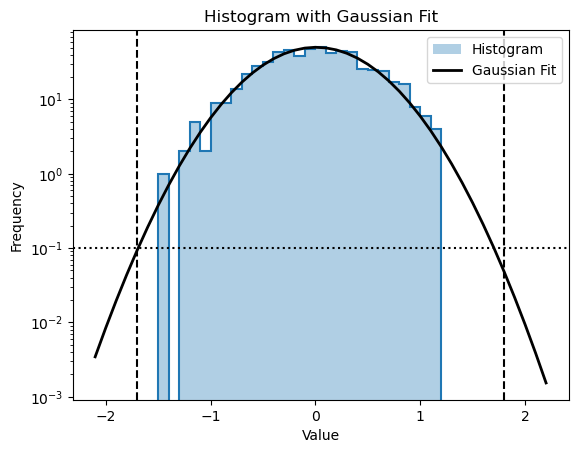

,tas,hour,month,time


16


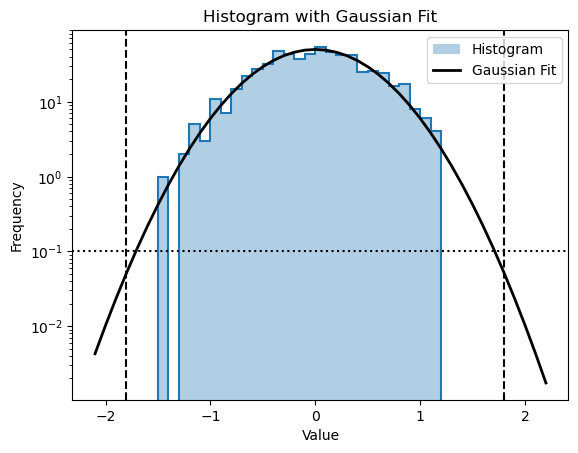

,tas,hour,month,time


17


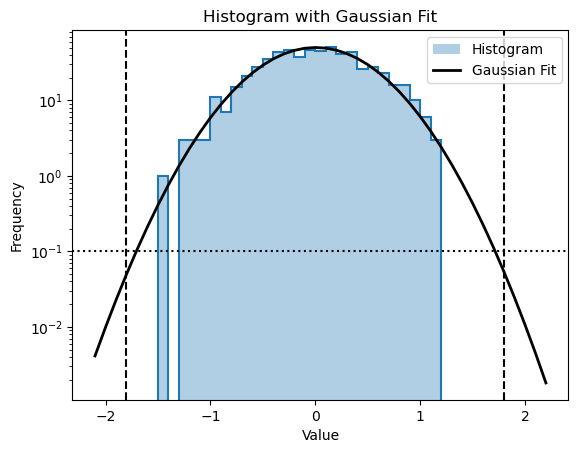

,tas,hour,month,time


18


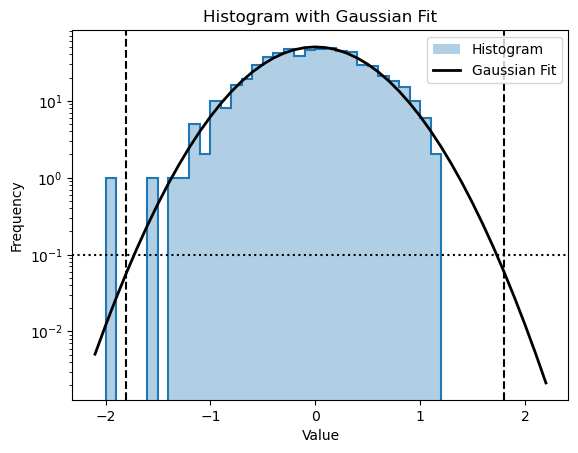

,tas,hour,month,time
145549,-1.934554,18,10,2019-10-30 18:31:00


19


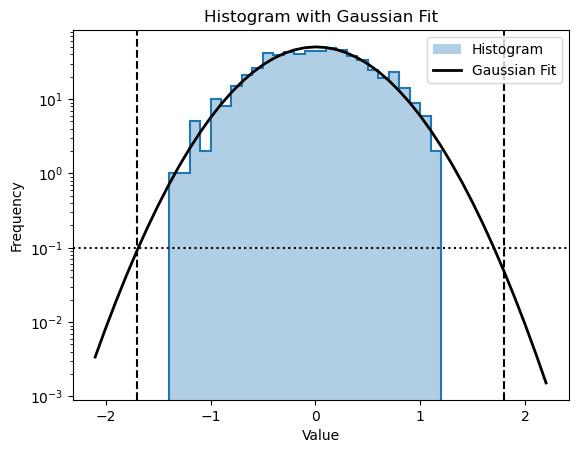

,tas,hour,month,time


20


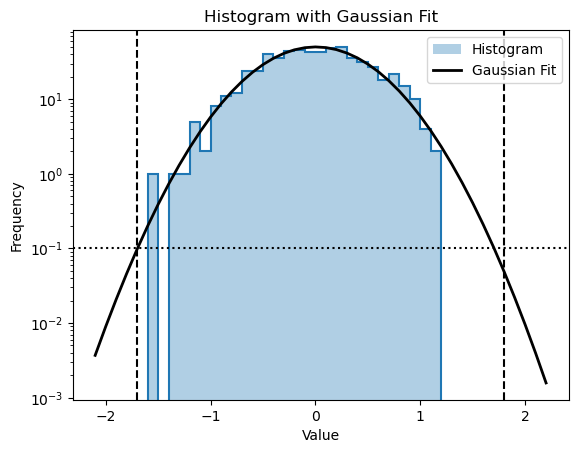

,tas,hour,month,time


21


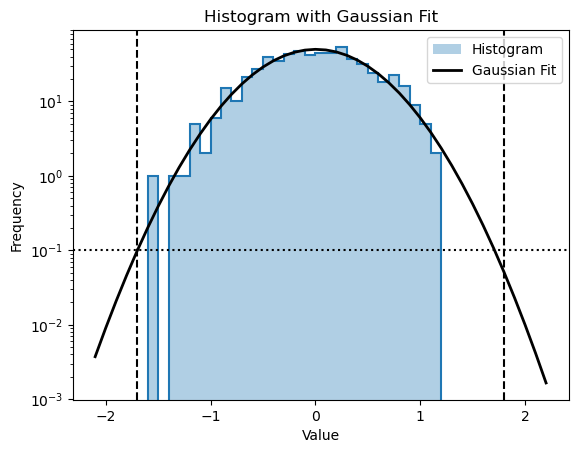

,tas,hour,month,time


22


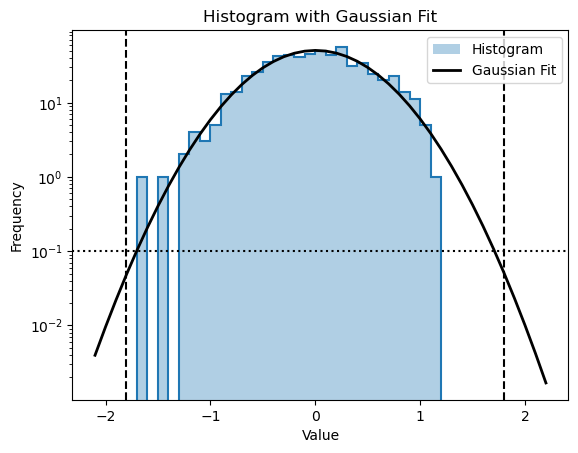

,tas,hour,month,time
145536,-1.613802,22,10,2019-10-29 22:31:00


23


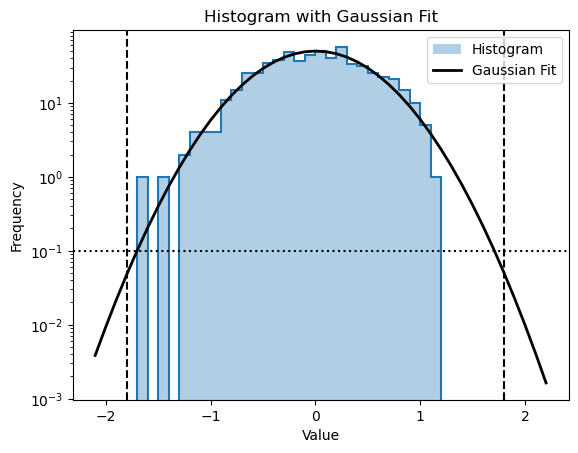

,tas,hour,month,time
145537,-1.64634,23,10,2019-10-29 23:31:00


In [210]:
for hour in range(0,24,1):
    series = data[(data.month==10)&(data.hour==hour)]
    print(hour)
    freq, bins, p, left, right = fit_normal(series['tas'], bin_size=0.10, plot=True)
    display(series[series['tas']<-1.6])

0


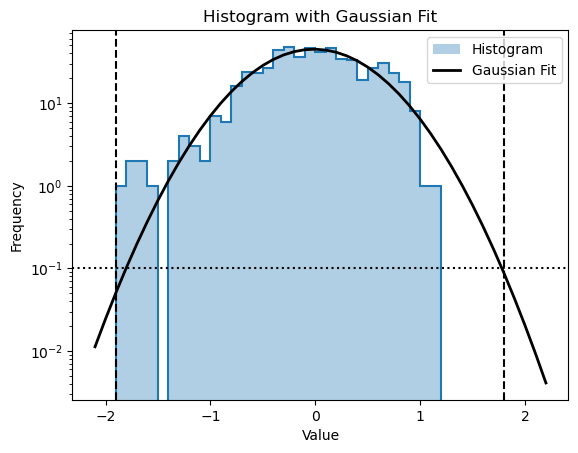

,tas,hour,month,time
11765,-1.649892,0,11,2003-11-26 00:45:00
11788,-1.706579,0,11,2003-11-27 00:45:00
11810,-1.732278,0,11,2003-11-28 00:45:00
11833,-1.803555,0,11,2003-11-29 00:45:00
11856,-1.655294,0,11,2003-11-30 00:45:00


1


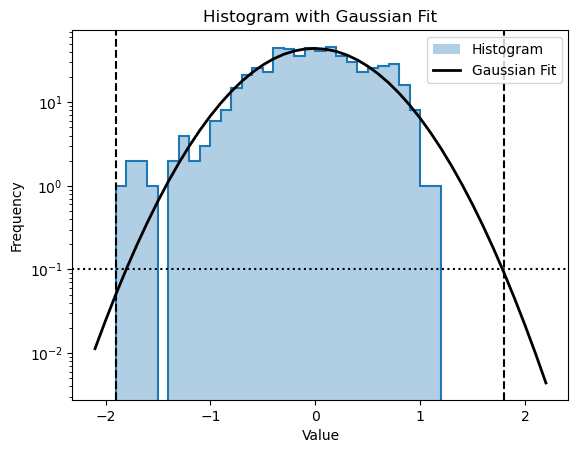

,tas,hour,month,time
11766,-1.655746,1,11,2003-11-26 01:45:00
11789,-1.709452,1,11,2003-11-27 01:45:00
11811,-1.738152,1,11,2003-11-28 01:45:00
11834,-1.805259,1,11,2003-11-29 01:45:00
11857,-1.650372,1,11,2003-11-30 01:45:00


2


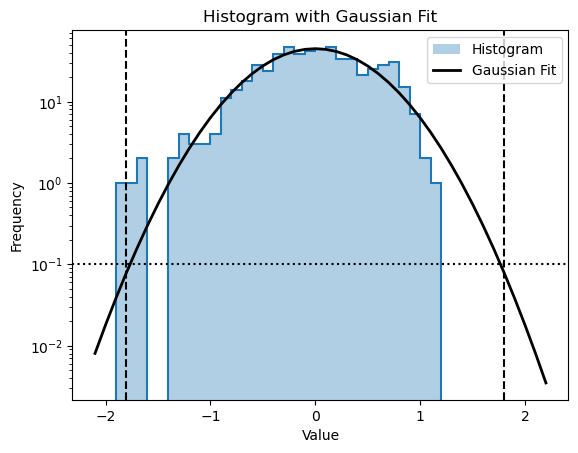

,tas,hour,month,time
11767,-1.661768,2,11,2003-11-26 02:45:00
11812,-1.743218,2,11,2003-11-28 02:45:00
11835,-1.802455,2,11,2003-11-29 02:45:00
11858,-1.645447,2,11,2003-11-30 02:45:00


3


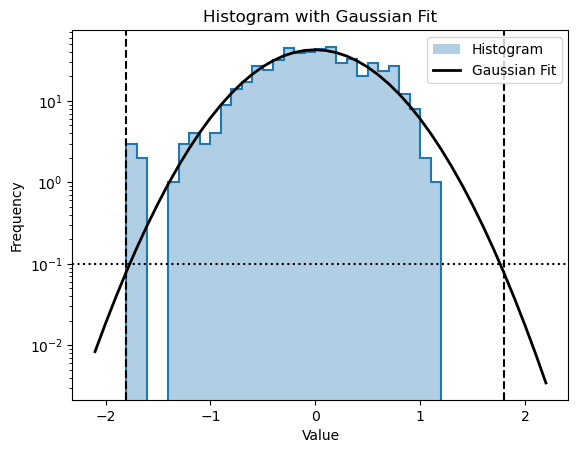

,tas,hour,month,time
11768,-1.667782,3,11,2003-11-26 03:45:00
11790,-1.713713,3,11,2003-11-27 03:45:00
11813,-1.747480,3,11,2003-11-28 03:45:00
11836,-1.796763,3,11,2003-11-29 03:45:00
11859,-1.641147,3,11,2003-11-30 03:45:00


4


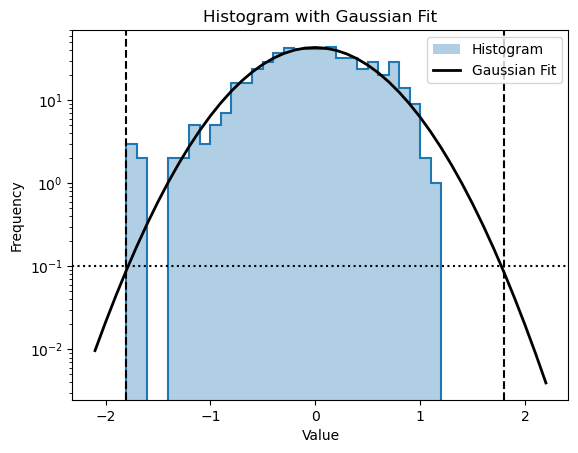

,tas,hour,month,time
11769,-1.675857,4,11,2003-11-26 04:45:00
11791,-1.720695,4,11,2003-11-27 04:45:00
11814,-1.754818,4,11,2003-11-28 04:45:00
11837,-1.788714,4,11,2003-11-29 04:45:00
11860,-1.633306,4,11,2003-11-30 04:45:00


5


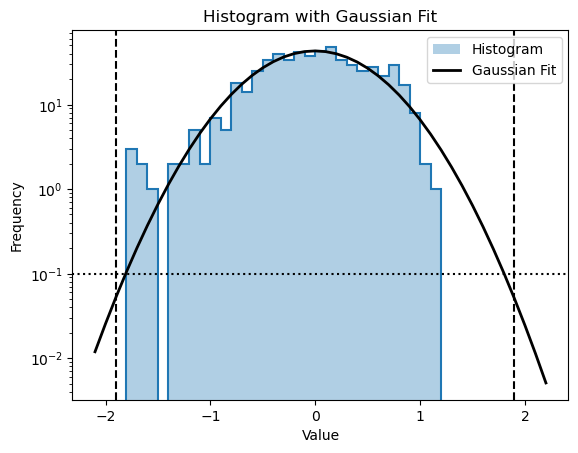

,tas,hour,month,time
11770,-1.683361,5,11,2003-11-26 05:45:00
11792,-1.726170,5,11,2003-11-27 05:45:00
11815,-1.762573,5,11,2003-11-28 05:45:00
11838,-1.780437,5,11,2003-11-29 05:45:00
11861,-1.619431,5,11,2003-11-30 05:45:00


6


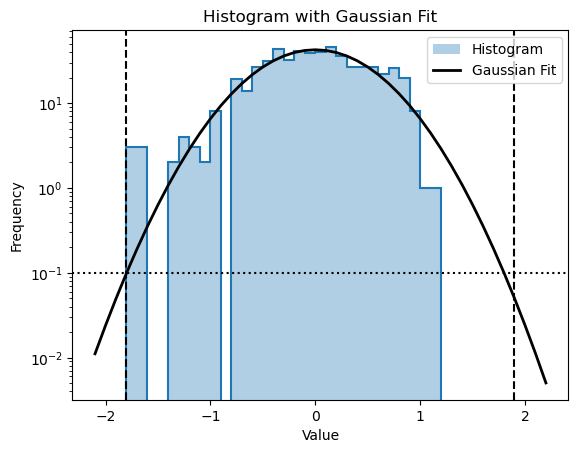

,tas,hour,month,time
11747,-1.606057,6,11,2003-11-25 06:45:00
11771,-1.687310,6,11,2003-11-26 06:45:00
11793,-1.730183,6,11,2003-11-27 06:45:00
11816,-1.767746,6,11,2003-11-28 06:45:00
11839,-1.772633,6,11,2003-11-29 06:45:00
11862,-1.601518,6,11,2003-11-30 06:45:00


7


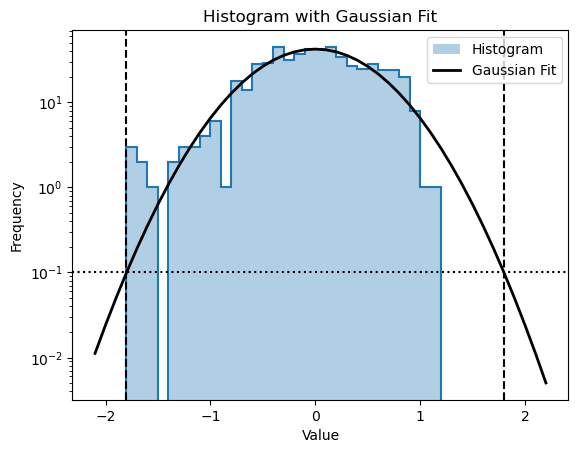

,tas,hour,month,time
11748,-1.621166,7,11,2003-11-25 07:45:00
11772,-1.690027,7,11,2003-11-26 07:45:00
11794,-1.733939,7,11,2003-11-27 07:45:00
11817,-1.772635,7,11,2003-11-28 07:45:00
11840,-1.764822,7,11,2003-11-29 07:45:00


8


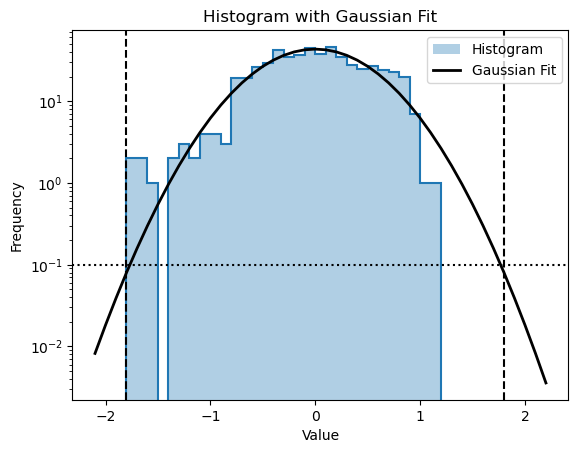

,tas,hour,month,time
11749,-1.632132,8,11,2003-11-25 08:45:00
11773,-1.688883,8,11,2003-11-26 08:45:00
11795,-1.735745,8,11,2003-11-27 08:45:00
11841,-1.757260,8,11,2003-11-29 08:45:00


9


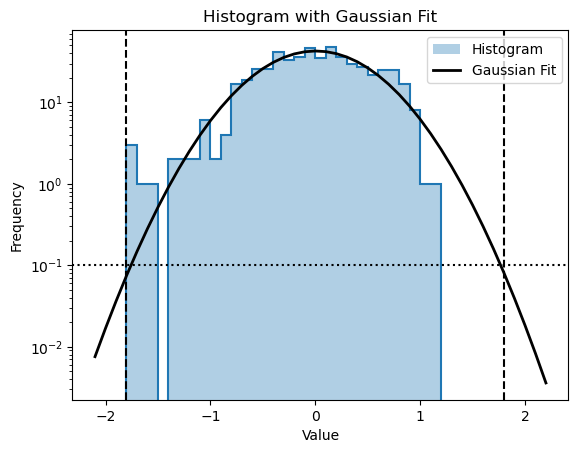

,tas,hour,month,time
11750,-1.639262,9,11,2003-11-25 09:45:00
11796,-1.737777,9,11,2003-11-27 09:45:00
11818,-1.776662,9,11,2003-11-28 09:45:00
11842,-1.750131,9,11,2003-11-29 09:45:00


10


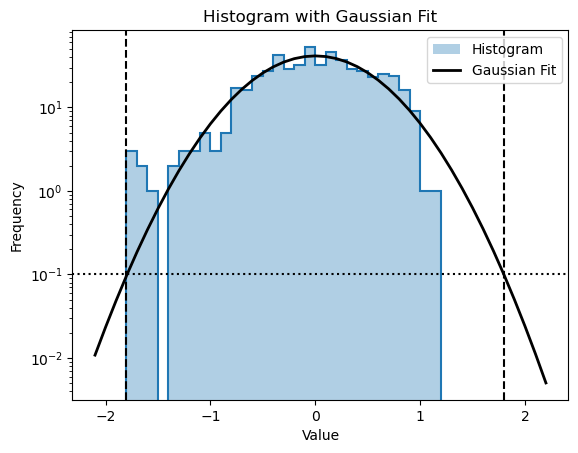

,tas,hour,month,time
11751,-1.644730,10,11,2003-11-25 10:45:00
11774,-1.690346,10,11,2003-11-26 10:45:00
11797,-1.737969,10,11,2003-11-27 10:45:00
11819,-1.781330,10,11,2003-11-28 10:45:00
11843,-1.743100,10,11,2003-11-29 10:45:00


11


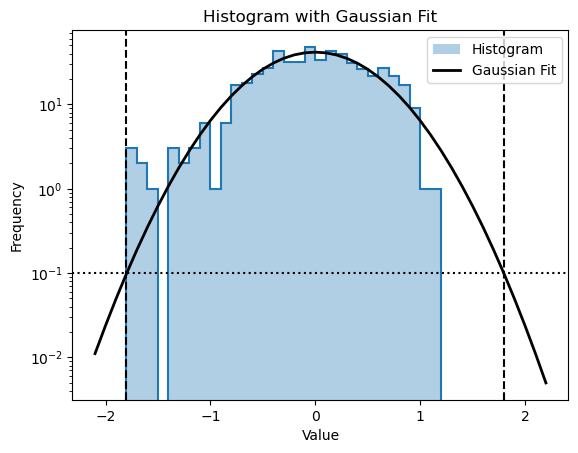

,tas,hour,month,time
11752,-1.648066,11,11,2003-11-25 11:45:00
11775,-1.692825,11,11,2003-11-26 11:45:00
11798,-1.739052,11,11,2003-11-27 11:45:00
11820,-1.782925,11,11,2003-11-28 11:45:00
11844,-1.735171,11,11,2003-11-29 11:45:00


12


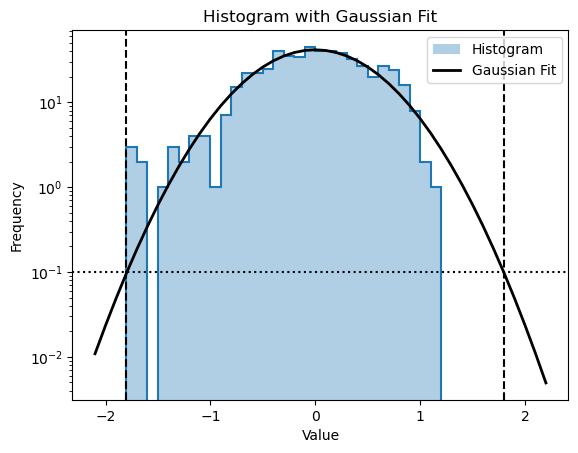

,tas,hour,month,time
11753,-1.647657,12,11,2003-11-25 12:45:00
11776,-1.692438,12,11,2003-11-26 12:45:00
11799,-1.740573,12,11,2003-11-27 12:45:00
11821,-1.778686,12,11,2003-11-28 12:45:00
11845,-1.726130,12,11,2003-11-29 12:45:00


13


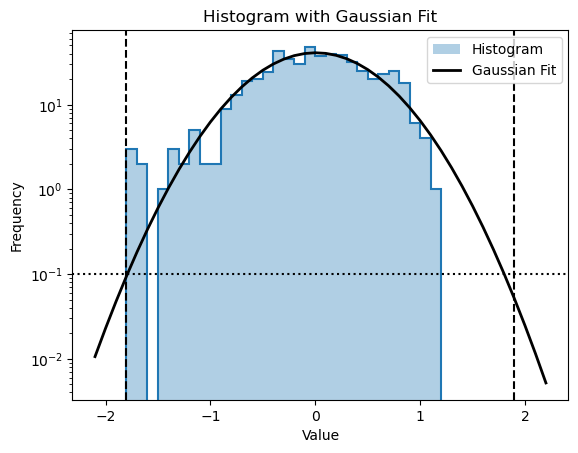

,tas,hour,month,time
11754,-1.645468,13,11,2003-11-25 13:45:00
11777,-1.693163,13,11,2003-11-26 13:45:00
11800,-1.741232,13,11,2003-11-27 13:45:00
11822,-1.772733,13,11,2003-11-28 13:45:00
11846,-1.717428,13,11,2003-11-29 13:45:00


14


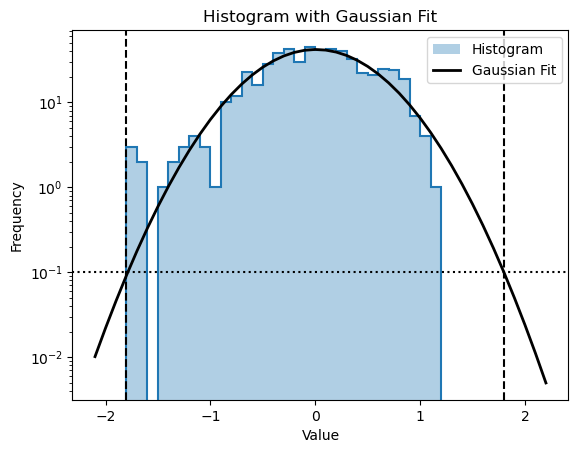

,tas,hour,month,time
11755,-1.641498,14,11,2003-11-25 14:45:00
11778,-1.692892,14,11,2003-11-26 14:45:00
11801,-1.744652,14,11,2003-11-27 14:45:00
11823,-1.765077,14,11,2003-11-28 14:45:00
11847,-1.709992,14,11,2003-11-29 14:45:00


15


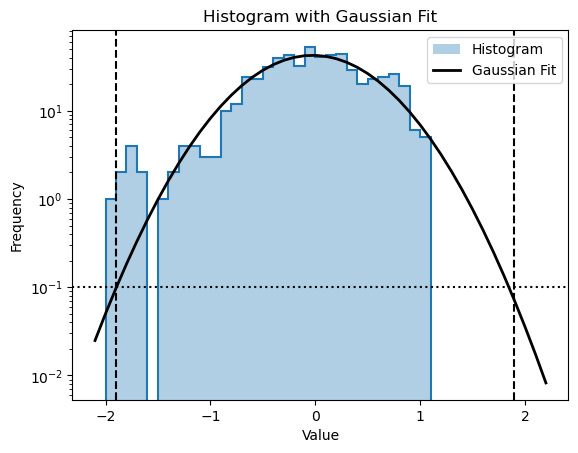

,tas,hour,month,time
11756,-1.637473,15,11,2003-11-25 15:45:00
11779,-1.695885,15,11,2003-11-26 15:45:00
11802,-1.751453,15,11,2003-11-27 15:45:00
11824,-1.764807,15,11,2003-11-28 15:45:00
11848,-1.704509,15,11,2003-11-29 15:45:00
145550,-1.940291,15,11,2019-11-01 15:31:00
145552,-1.895398,15,11,2019-11-02 15:31:00
145554,-1.840801,15,11,2019-11-03 15:31:00
145556,-1.758167,15,11,2019-11-04 15:31:00


16


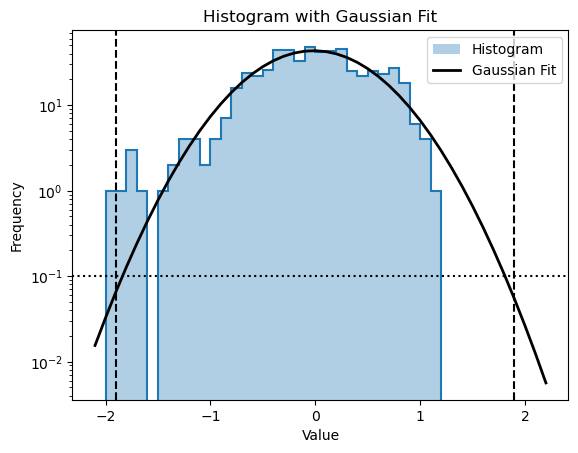

,tas,hour,month,time
11757,-1.637736,16,11,2003-11-25 16:45:00
11780,-1.701307,16,11,2003-11-26 16:45:00
11803,-1.756748,16,11,2003-11-27 16:45:00
11825,-1.772994,16,11,2003-11-28 16:45:00
145551,-1.919222,16,11,2019-11-01 16:31:00
145553,-1.869957,16,11,2019-11-02 16:31:00


17


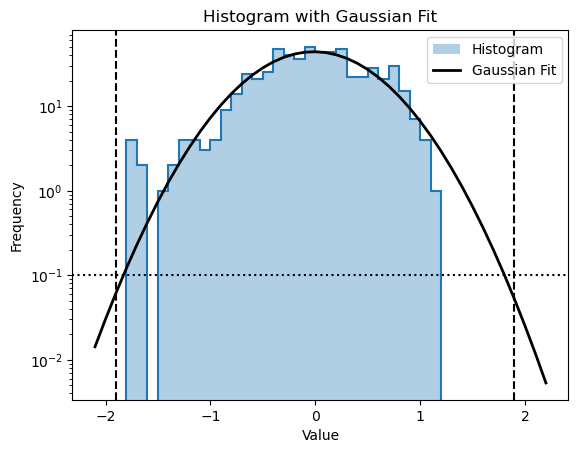

,tas,hour,month,time
11758,-1.639783,17,11,2003-11-25 17:45:00
11781,-1.705965,17,11,2003-11-26 17:45:00
11804,-1.757219,17,11,2003-11-27 17:45:00
11826,-1.779304,17,11,2003-11-28 17:45:00
11849,-1.699314,17,11,2003-11-29 17:45:00
145557,-1.712226,17,11,2019-11-04 17:31:00


18


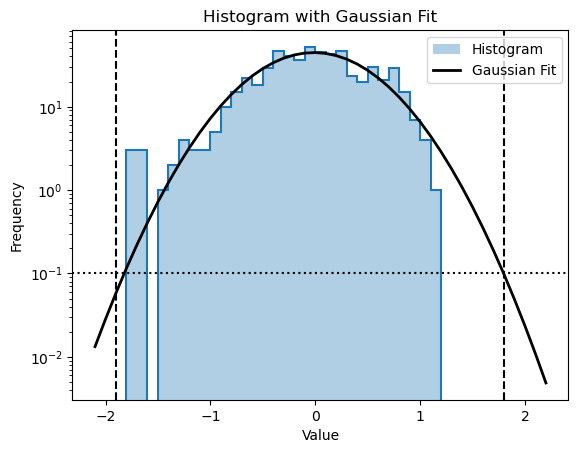

,tas,hour,month,time
11759,-1.642266,18,11,2003-11-25 18:45:00
11782,-1.708955,18,11,2003-11-26 18:45:00
11805,-1.753317,18,11,2003-11-27 18:45:00
11827,-1.784618,18,11,2003-11-28 18:45:00
11850,-1.692777,18,11,2003-11-29 18:45:00
145558,-1.665744,18,11,2019-11-04 18:31:00


19


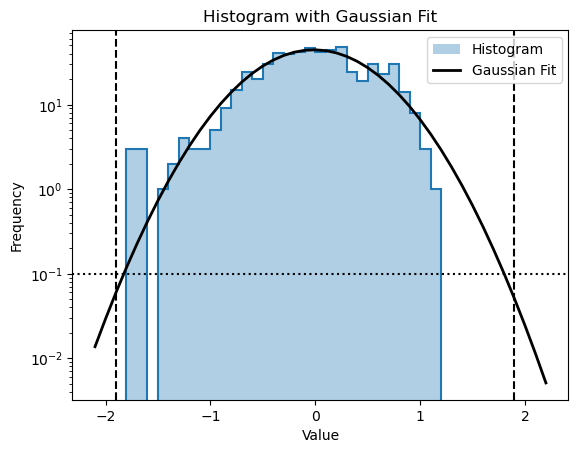

,tas,hour,month,time
11760,-1.643854,19,11,2003-11-25 19:45:00
11783,-1.711707,19,11,2003-11-26 19:45:00
11806,-1.745048,19,11,2003-11-27 19:45:00
11828,-1.788750,19,11,2003-11-28 19:45:00
11851,-1.684026,19,11,2003-11-29 19:45:00
145559,-1.618630,19,11,2019-11-04 19:31:00


20


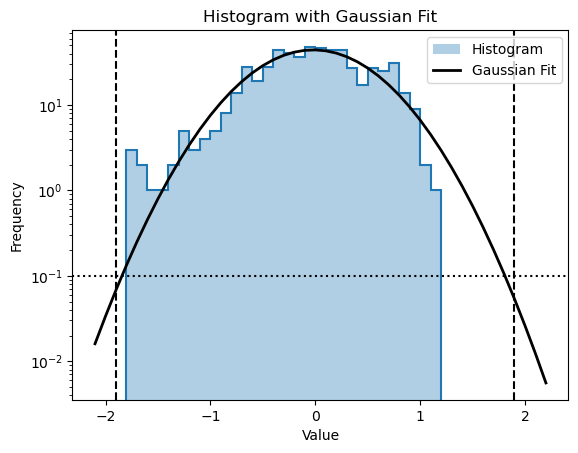

,tas,hour,month,time
11761,-1.642415,20,11,2003-11-25 20:45:00
11784,-1.714018,20,11,2003-11-26 20:45:00
11807,-1.737980,20,11,2003-11-27 20:45:00
11829,-1.790163,20,11,2003-11-28 20:45:00
11852,-1.675675,20,11,2003-11-29 20:45:00


21


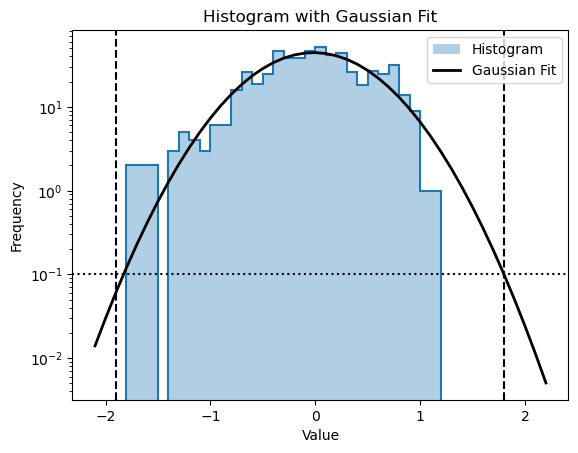

,tas,hour,month,time
11762,-1.640572,21,11,2003-11-25 21:45:00
11785,-1.712287,21,11,2003-11-26 21:45:00
11830,-1.793372,21,11,2003-11-28 21:45:00
11853,-1.669852,21,11,2003-11-29 21:45:00


22


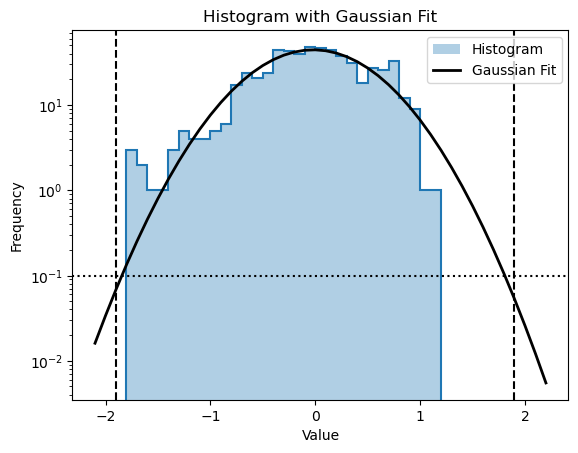

,tas,hour,month,time
11763,-1.641003,22,11,2003-11-25 22:45:00
11786,-1.709554,22,11,2003-11-26 22:45:00
11808,-1.732934,22,11,2003-11-27 22:45:00
11831,-1.796284,22,11,2003-11-28 22:45:00
11854,-1.663923,22,11,2003-11-29 22:45:00


23


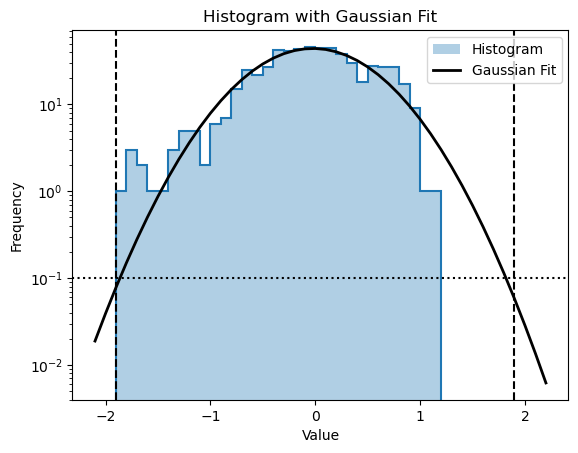

,tas,hour,month,time
11764,-1.644481,23,11,2003-11-25 23:45:00
11787,-1.706653,23,11,2003-11-26 23:45:00
11809,-1.730344,23,11,2003-11-27 23:45:00
11832,-1.798902,23,11,2003-11-28 23:45:00
11855,-1.658722,23,11,2003-11-29 23:45:00
145555,-1.802276,23,11,2019-11-03 23:31:00


In [232]:
for hour in range(0,24,1):
    series = data[(data.month==11)&(data.hour==hour)]
    print(hour)
    freq, bins, p, left, right = fit_normal(series['tas'], bin_size=0.10, plot=True)
    display(series[series['tas']<-1.6])

In [432]:
test_df = qaqc_climatological_outlier(stn_to_qaqc, verbose=verbose, local=True, plot=True)

06-28-2024 18:27:34 : 	 Running qaqc_climatological_outlier on ['tas', 'tdps_derived']
06-28-2024 18:27:34 : 	 Checking for climatological outliers in: tas
06-28-2024 18:27:34 : 	 Flagging outliers in tas
06-28-2024 18:27:50 : 	 Checking for climatological outliers in: tdps_derived
06-28-2024 18:27:50 : 	 Flagging outliers in tdps_derived


,tdps_derived,year,month,day,hour,time,raw_tdps_derived,flag


In [433]:
fig,ax = plt.subplots(figsize=(10,3))

df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2003-11-28"),np.datetime64("2003-12-01"))
ax.axvline(np.datetime64("2003-11-29 02:45:00"), ls=":", c="C0")
ax.set_ylim(255,285)

axt = ax.twiny()
df.plot(x="time", y="tas", ax=axt, marker=".", color="C1")
axt.set_xlim(np.datetime64("2002-11-28"),np.datetime64("2002-12-01"))
axt.set_ylim(255,285)

# fig,ax = plt.subplots(figsize=(10,3))
axtt = axt.twiny()
df.plot(x="time", y="tas", ax=axtt, marker=".", color="C2")
axtt.set_xlim(np.datetime64("2016-11-28"),np.datetime64("2016-12-01"))
axtt.set_ylim(255,285)

axttt = axtt.twiny()
df.plot(x="time", y="tas", ax=axttt, marker=".", color="C3")
axttt.set_xlim(np.datetime64("2005-11-28"),np.datetime64("2005-12-01"))
axttt.set_ylim(255,285)

(255.0, 285.0)

(255.0, 285.0)

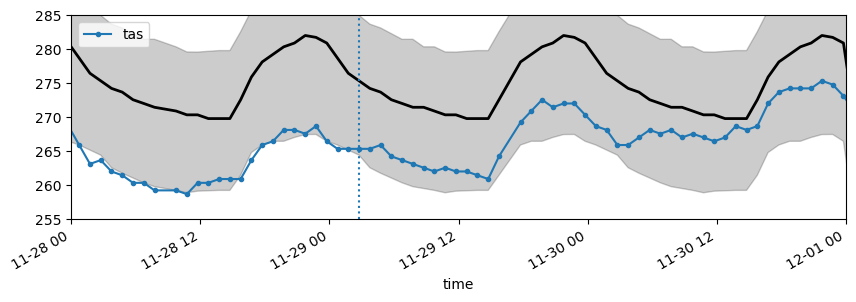

In [280]:
fig,ax = plt.subplots(figsize=(10,3))

ax.plot(df.time, df.groupby(["month","hour"]).tas.transform(lambda row: np.nanmedian(row)), lw=2, c="k")
y1 = stn_to_qaqc.groupby(["month","hour"]).tas.transform(lambda row: np.percentile(row,  1)).interpolate(method="linear")
y2 = stn_to_qaqc.groupby(["month","hour"]).tas.transform(lambda row: np.percentile(row, 99))
ax.fill_between(df.time, y1, y2, color="k", alpha=0.2)

df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2003-11-28"),np.datetime64("2003-12-01"))
ax.axvline(np.datetime64("2003-11-29 02:45:00"), ls=":", c="C0")
ax.set_ylim(255,285)
